# Downloading and Processing LOCA2

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

This is a guide to downloading and processing LOCA2 data.

[LOCA2 Website](https://loca.ucsd.edu/)

# Table of Contents

1. [Creating Directories](#Creating-Directories)
2. [Downloading Files](#Downloading-Files)
3. [Currently Available Datasets](#Currently-Available-Datasets)
4. [Processing Data](#Processing-Data)
5. [Working with the Data](#Working-with-the-Data)

# Creating Directories

Directories can be created using the script `create_dir.sh`. Simply copy this script into a directory of your choosing and then run the script:

```

mkdir LOCA2
cd LOCA2
cp [original_path]/create_dir.sh .
bash create_dir.sh

```

This creates a system of subdirectories like so:

### LOCA2
- ACCESS-CM2
    - historical
    - ssp245
    - ssp370
    - ssp585
- ACCESS-ESM1-5
    - historical
    - ssp245 
    ...
    
and so on for each model.

# Downloading Files

Files can be downloaded using `LOCA2_download.py`. 

You will need urllib, bs4, requests, fnmatch, pathlib, and argparse to run this file. These should be automatically be available with Python 3.

This file downloads daily data for every model and experiment ID (e.g. r1i1p1f1, r2i1p1f3) available for LOCA2. It downloads data into a file structure similar to what is created using `create_dir.sh`.

To run this file, you will need to provide a variable and path_out.
- `variable` (str) - The only variables available are:
    - pr (Precipitation)
    - tasmax (Daily maximum surface air temperature)
    - tasmin (Daily minimum surface air temperature)
- `path_out` (str) - The location you'd like to download the files to

Example Code:
```
python LOCA2_download.py --variable="pr" --path_out="/data/keeling/a/cristi/a/downscaled_data/LOCA2"

```

# Currently Available Datasets

Currently, we have daily data downloaded for all of pr, tasmax, and tasmin for all available models and datasets. 

All data is in `/data/keeling/a/cristi/a/downscaled_data/LOCA2`.

The typical path structure for each dataset is as so:

` [model_name]/[scenario]/[variable_name].[model].[scenario].[experiment_id].[time_period].LOCA_16thdeg_v[time_of_last_update].cent.nc `

Example:

` /ACCESS-CM2/historical/pr.ACCESS-CM2.historical.r1i1p1f1.1950-2014.LOCA_16thdeg_v20240915.cent.nc`

The available models and experiment IDs are in the [README.md](../README.md)

Availability:

| Scenario | Time Periods | Variables | Temporal Resolution | 
| :---: | :---: | :---: | :---: |
| historical | 1950-2014 | pr, tasmax, tasmin | daily |
| ssp245 | 2015-2044, 2045-2074, 2075-2100 | pr, tasmax, tasmin | daily |
| ssp370 | 2015-2044, 2045-2074, 2075-2100 | pr, tasmax, tasmin | daily |
| ssp585 | 2015-2044, 2045-2074, 2075-2100 | pr, tasmax, tasmin | daily |



# Processing Data

Processing data can be done with ` LOCA2_processor.py `.

You will need xarray, glob, pandas, os, and argparse to run this file.

This file processes given LOCA2 datasets into an Xarray dataset. It specifically focuses in on the Illinois region (which can be edited in Line 76) and takes a mean over Experiment IDs for each model.

Inputs:
 - `scenario` (str)
     - historical 
     - ssp245 
     - ssp370 
     - ssp585
 - `variable` (str)
     - pr  
     - tasmax
     - tasmin
 - `year_start` (int) - First year you'd like to request
 - `year_end` (int) - Last year you'd like to request (inclusive)
 - `out_path` (str) - Directory you'd like to save the dataset in
 
 Example Code: 
 
```
python LOCA2_processor.py --scenario="ssp245" --variable="tasmin" --year_start=2043 --year_end=2045 --out_path="."

```

results in a file in your current directory called ` LOCA2_IL_tasmin_ssp245_2043-2045_[current date].nc `

# Working with the Data

Let's try loading `LOCA2_IL_tasmin_ssp245_2043-2045.nc`!

In [3]:
tasmin_data = xr.open_dataset('/data/keeling/a/mailes2/a/downscaling/LOCA2_IL_tasmin_ssp245_2043-2045_2025-02-03.nc')
tasmin_data.load()

<xarray.Dataset>
Dimensions:  (lon: 109, lat: 108, time: 1096, ens_mem: 9, model: 24)
Coordinates:
  * lon      (lon) float64 267.2 267.3 267.3 267.4 ... 273.8 273.8 273.9 274.0
  * lat      (lat) float64 36.03 36.09 36.16 36.22 ... 42.53 42.59 42.66 42.72
  * time     (time) datetime64[ns] 2043-01-01 2043-01-02 ... 2045-12-31
  * ens_mem  (ens_mem) int64 0 1 2 3 4 5 6 7 8
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'TaiESM1'
Data variables:
    tasmin   (model, ens_mem, time, lat, lon) float32 263.7 263.8 ... nan nan
Attributes:
    history:   pierce 2023-08-12 16:06:31.41634 /net/mead24/data/LOCA2_CONUS_...

This dataset has 5 dimensions.

- `lon` - Longitude. To cover Illinois, it extends from 267.2 to 274 lon with a resolution of 6 km.
- `lat` - Latitude. This extends from 36.03 to 42.72 lat with a resolution of 6 km also.
- `time` - This covers the date range we gave it (2043-01-01 to 2045-12-31) and has a daily resolution.
- `model` - This dimension has all the models
- `ens_mem` - This dimension contains the ensemble members for each model. The amount varies per model, but they can have anywhere from 1 to 10. The names are simply referred to as 0-9 since the ensemble members are the same but with different initial conditions for a model.

If you want to take a mean over the ensemble members and models, we suggest taking a mean over the ensemble members first to ensure that the weighting for each model remains even as you take a mean over them.

Let's look at a multi-model mean at the time 2044-06-10.

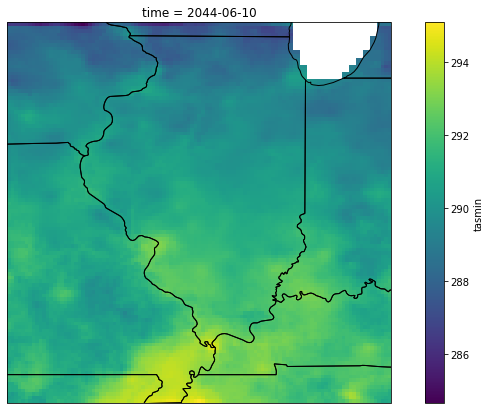

In [4]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree())
tasmin_data.tasmin.sel(time='2044-06-10').mean('ens_mem').mean('model').plot()
ax.add_feature(cfeature.STATES)